### Çizgilerin Kodlanması

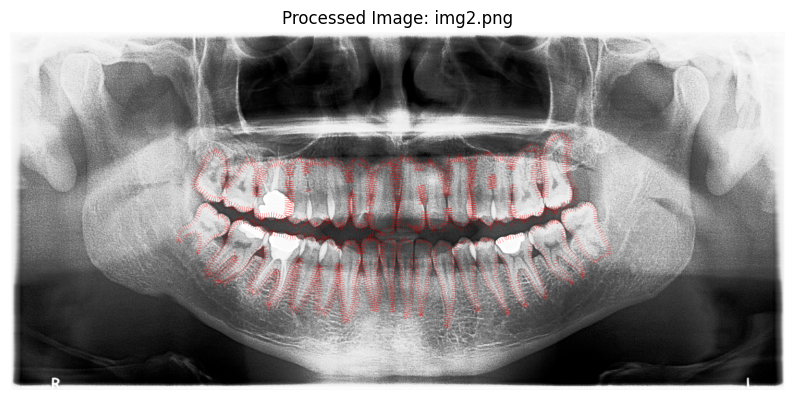

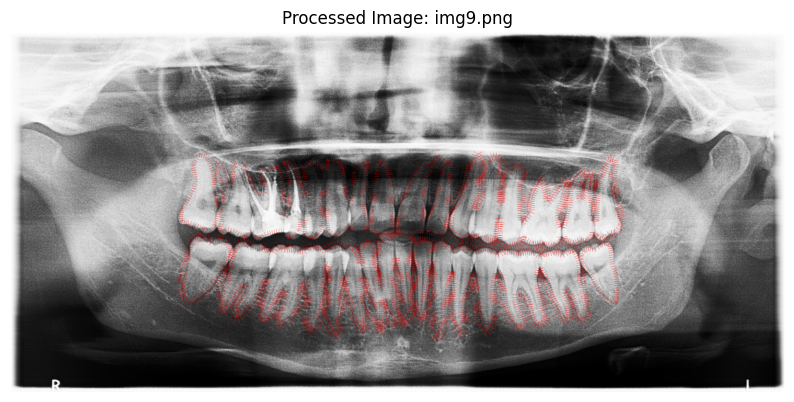

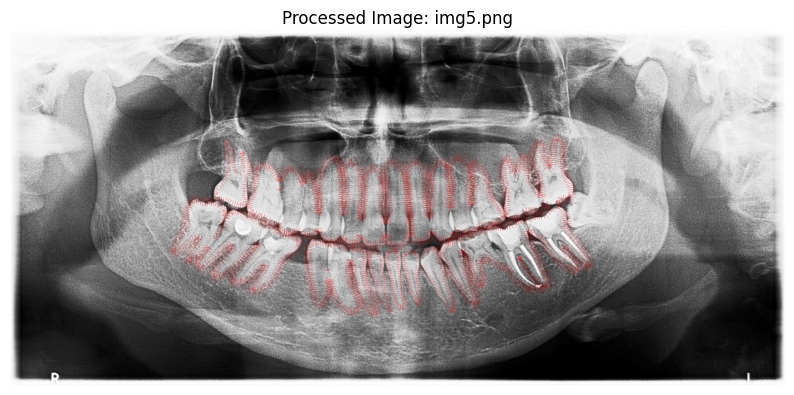

HOG özellik vektörleri kaydedildi.


In [ ]:
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt
from skimage.feature import hog
import pickle

def normalize_image(image):
    return cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)

def histogram_equalization(image):
    return cv2.equalizeHist(image)

def sharpen_image(image):
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    return cv2.filter2D(image, -1, kernel)

def gaussian_filter(image):
    return cv2.GaussianBlur(image, (5, 5), 0)

# Ön işleme uygulanacak görüntüleri tanımlayın
image_paths = ["img2.png", "img9.png", "img5.png"]
label_paths = ["label1.png", "label8.png", "label4.png"]

hog_vectors = []

for img_path, label_path in zip(image_paths, label_paths):
    label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)

    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Ön işleme
    img_gray = normalize_image(img_gray)
    img_gray = histogram_equalization(img_gray)
    img_gray = sharpen_image(img_gray)
    img_gray = gaussian_filter(img_gray)

    blurred_image = cv2.GaussianBlur(label, (5, 5), 0)
    edges = cv2.Canny(blurred_image, 50, 150)

    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contour_indices = []

    for contour in contours:
        indices = [(point[0][1], point[0][0]) for point in contour]
        contour_indices.append(indices)

    output_image = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2BGR)
    sparsity_factor = 8
    length = 15
    d = 5
    line_gray_values_list = []

    for indices in contour_indices:
        for i in range(0, len(indices), sparsity_factor):
            y, x = indices[i]
            prev_idx = max(i - d, 0)
            next_idx = min(i + d, len(indices) - 1)
            y1, x1 = indices[prev_idx]
            y2, x2 = indices[next_idx]

            dx = x2 - x1
            dy = y2 - y1

            if dx == 0 and dy == 0:
                continue

            perpendicular_angle = math.atan2(-dx, dy)
            dx_line = int(length * math.cos(perpendicular_angle))
            dy_line = int(length * math.sin(perpendicular_angle))
            x_end, y_end = x + dx_line, y + dy_line

            line_gray_values = []
            num_points = length
            for t in range(num_points + 1):
                x_pt = int(x + t * (x_end - x) / num_points)
                y_pt = int(y + t * (y_end - y) / num_points)

                if 0 <= y_pt < img_gray.shape[0] and 0 <= x_pt < img_gray.shape[1]:
                    gray_value = img_gray[y_pt, x_pt]
                    line_gray_values.append(gray_value)
                else:
                    line_gray_values.append(0)

            line_gray_values_list.append(line_gray_values)
            cv2.line(output_image, (x, y), (x_end, y_end), (0, 0, 255), 1)

    num_lines = len(line_gray_values_list)
    line_gray_values_matrix = np.zeros((num_lines, length + 1), dtype=np.uint8)

    for idx, line_gray_values in enumerate(line_gray_values_list):
        line_gray_values_matrix[idx, :] = line_gray_values

    hog_features = hog(line_gray_values_matrix, orientations=8, pixels_per_cell=(4, 4),
                       cells_per_block=(2, 2), feature_vector=True)
    hog_vectors.append(hog_features)

    output_image_rgb = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 10))
    plt.imshow(output_image_rgb)
    plt.title(f'Processed Image: {img_path}')
    plt.axis('off')
    plt.show()

with open('hog_vectors.pkl', 'wb') as f:
    pickle.dump(hog_vectors, f)

print("HOG özellik vektörleri kaydedildi.")


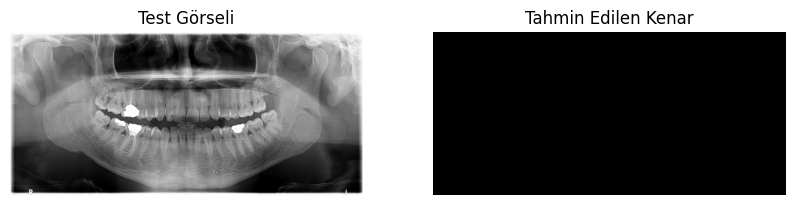

In [ ]:
import cv2
import numpy as np
from skimage.feature import hog
from scipy.spatial.distance import cosine
import matplotlib.pyplot as plt
import pickle

# Ön işleme adımları
def normalize_image(image):
    return cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)

def histogram_equalization(image):
    return cv2.equalizeHist(image)

def sharpen_image(image):
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    return cv2.filter2D(image, -1, kernel)

def gaussian_filter(image):
    return cv2.GaussianBlur(image, (5, 5), 0)

# Test görüntüsünün yolunu belirleyin
test_image_path = "img2.png"

# Modelleme aşamasında kullanılan HOG parametrelerini belirleyin
hog_params = {
    "orientations": 9,
    "pixels_per_cell": (2, 2),
    "cells_per_block": (2, 2),
    "feature_vector": True
}

# Modelleme aşamasında kaydedilen HOG vektörlerini yükleyin
with open('hog_vectors.pkl', 'rb') as f:
    model_hog_vectors = pickle.load(f)

# Test görüntüsünü yükle
test_image = cv2.imread(test_image_path, cv2.IMREAD_COLOR)
test_image_gray = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)

# Ön işleme adımları
test_image_gray = normalize_image(test_image_gray)
test_image_gray = histogram_equalization(test_image_gray)
test_image_gray = sharpen_image(test_image_gray)
test_image_gray = gaussian_filter(test_image_gray)

# Kenar tespiti
edges = cv2.Canny(test_image_gray, 30, 100)

# Kenar noktalarını belirleme
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
contour_indices = []
for contour in contours:
    indices = [(point[0][1], point[0][0]) for point in contour]
    contour_indices.append(indices)

# mxm boyutunda patch çıkarma ve özellik kodlama
patch_size = 16  # Patch boyutu (mxm)
half_patch = patch_size // 2
predicted_labels = np.zeros(test_image_gray.shape, dtype=np.uint8)

for indices in contour_indices:
    for y, x in indices:
        # Patch sınırlarını kontrol et
        if (y - half_patch >= 0 and y + half_patch < test_image_gray.shape[0] and
                x - half_patch >= 0 and x + half_patch < test_image_gray.shape[1]):
            # Patch çıkar
            patch = test_image_gray[y - half_patch:y + half_patch + 1, x - half_patch:x + half_patch + 1]

            # HOG özelliklerini çıkar
            patch_hog = hog(patch, **hog_params)

            # Model HOG vektörleri ile karşılaştırma
            similarities = [1 - cosine(patch_hog, model_hog) for model_hog in model_hog_vectors if len(patch_hog) == len(model_hog)]
            if similarities:  # Karşılaştırılacak bir şey varsa
                max_similarity = max(similarities)

                # Eşik değerine göre tahmin yap
                threshold = 0.5  # Daha düşük eşik değeri
                if max_similarity >= threshold:
                    predicted_labels[y, x] = 255  # Organ kenarı

# Sonuçları görselleştir
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.title("Test Görseli")
plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Tahmin Edilen Kenar")
plt.imshow(predicted_labels, cmap='gray')
plt.axis('off')

plt.show()


### Patch ile kodlama

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog
import pickle

# Kenar bulma fonksiyonu (bwboundary)
def find_boundaries(label):
    # Kenar tespiti için kontur bulma
    contours, _ = cv2.findContours(label, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return contours

# Patch çıkarma fonksiyonu
def extract_patches(image, contours, patch_size):
    patches = []
    half_patch = patch_size // 2

    for contour in contours:
        for point in contour:
            y, x = point[0]
            if (
                x - half_patch >= 0 and x + half_patch < image.shape[1] and
                y - half_patch >= 0 and y + half_patch < image.shape[0]
            ):
                patch = image[y - half_patch: y + half_patch, x - half_patch: x + half_patch]
                patches.append(patch)
    return patches

# HOG kodlama fonksiyonu
def compute_hog_features(patches):
    hog_features = []
    for patch in patches:
        features = hog(patch, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=False)
        hog_features.append(features)
    return np.mean(hog_features, axis=0)  # Tek bir vektör olarak birleştir

# Görüntü ve label yükleme
images = ["img2.png", "img9.png", "img5.png"]
labels = ["label1.png", "label8.png", "label4.png"]

final_hog_vector = []
patch_size = 16  # Patch boyutu

for img_path, label_path in zip(images, labels):
    # Görüntü ve label yükleme
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)

    # Label üzerindeki kenarları bul
    contours = find_boundaries(label)

    # Kenarlardan patch'ler çıkar
    patches = extract_patches(image, contours, patch_size)

    # HOG özelliklerini hesapla
    hog_vector = compute_hog_features(patches)
    final_hog_vector.append(hog_vector)

# Tüm HOG vektörlerini birleştir
final_hog_vector = np.mean(final_hog_vector, axis=0)

# HOG vektörünü .pkl olarak kaydet
with open("hog_features.pkl", "wb") as file:
    pickle.dump(final_hog_vector, file)

print("HOG vektörleri başarıyla kaydedildi!")


HOG vektörleri başarıyla kaydedildi!


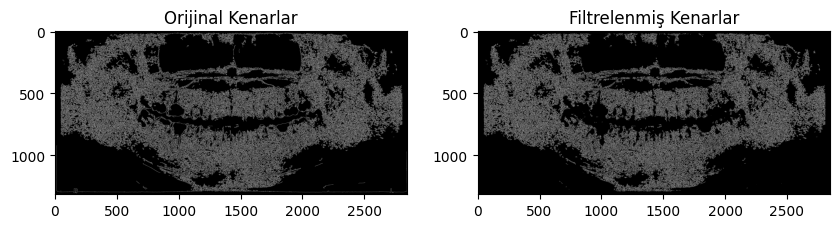

Test görüntüsü işlendi ve sonuç görselleştirildi.


In [ ]:
import cv2
import numpy as np
from skimage.feature import hog
import pickle
from scipy.ndimage import gaussian_filter

# Görüntü normalize etme fonksiyonu
def normalize_image(image):
    return (image - np.min(image)) / (np.max(image) - np.min(image)) * 255

# Histogram eşitleme fonksiyonu
def histogram_equalization(image):
    return cv2.equalizeHist(image.astype(np.uint8))

# Görüntü keskinleştirme fonksiyonu
def sharpen_image(image):
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    return cv2.filter2D(image, -1, kernel)

# Kenar bulma fonksiyonu
def find_edges(image):
    edges = cv2.Canny(image.astype(np.uint8), 50, 150)
    return edges

# Patch çıkarma fonksiyonu
def extract_patches_from_edges(image, edges, patch_size):
    patches = []
    half_patch = patch_size // 2

    points = np.argwhere(edges > 0)
    for y, x in points:
        if (
            x - half_patch >= 0 and x + half_patch < image.shape[1] and
            y - half_patch >= 0 and y + half_patch < image.shape[0]
        ):
            patch = image[y - half_patch: y + half_patch, x - half_patch: x + half_patch]
            patches.append((y, x, patch))
    return patches

# HOG özelliklerini hesaplama fonksiyonu
def compute_hog_for_patch(patch):
    return hog(patch, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=False)

# HOG benzerlik kontrolü
def is_similar(hog_vector, stored_hog_vector, threshold=0.8):
    similarity = np.dot(hog_vector, stored_hog_vector) / (np.linalg.norm(hog_vector) * np.linalg.norm(stored_hog_vector))
    return similarity >= threshold

# Test görüntüsü ve kaydedilen HOG vektörü yükleme
test_image_path = "img2.png"
test_image_gray = cv2.imread(test_image_path, cv2.IMREAD_GRAYSCALE)

with open("hog_features.pkl", "rb") as file:
    stored_hog_vector = pickle.load(file)

# Ön işleme adımları
test_image_gray = normalize_image(test_image_gray)
test_image_gray = histogram_equalization(test_image_gray)
test_image_gray = sharpen_image(test_image_gray)
test_image_gray = gaussian_filter(test_image_gray, sigma=1)

# Kenarları bulma
edges = find_edges(test_image_gray)

# Kenarlardan patch çıkarma
patch_size = 16
patches = extract_patches_from_edges(test_image_gray, edges, patch_size)

# HOG ile kodlama ve benzerlik kontrolü
output_edges = np.zeros_like(edges)

for y, x, patch in patches:
    hog_vector = compute_hog_for_patch(patch)
    if is_similar(hog_vector, stored_hog_vector):
        output_edges[y, x] = 255

# Sonuç görselleştirme
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Orijinal Kenarlar")
plt.imshow(edges, cmap="gray")

plt.subplot(1, 2, 2)
plt.title("Filtrelenmiş Kenarlar")
plt.imshow(output_edges, cmap="gray")

plt.show()
print("Test görüntüsü işlendi ve sonuç görselleştirildi.")


### Label kenarını k çaplı dairesel bir yapısal elementle genişletilmesi ve bölgeye karşılık gelen kenar bilgisini kodlanması

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog
import pickle

# Kenar bulma fonksiyonu (bwboundary)
def find_boundaries(label):
    # Kenar tespiti için kontur bulma
    contours, _ = cv2.findContours(label, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return contours

# Patch çıkarma fonksiyonu
def extract_patches(image, contours, patch_size):
    patches = []
    half_patch = patch_size // 2

    for contour in contours:
        for point in contour:
            y, x = point[0]
            if (
                x - half_patch >= 0 and x + half_patch < image.shape[1] and
                y - half_patch >= 0 and y + half_patch < image.shape[0]
            ):
                patch = image[y - half_patch: y + half_patch, x - half_patch: x + half_patch]
                patches.append(patch)
    return patches

# HOG kodlama fonksiyonu
def compute_hog_features(patches):
    hog_features = []
    for patch in patches:
        features = hog(patch, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=False)
        hog_features.append(features)
    return np.mean(hog_features, axis=0)  # Tek bir vektör olarak birleştir

# Görüntü ve label yükleme
images = ["img2.png", "img9.png", "img5.png"]
labels = ["label1.png", "label8.png", "label4.png"]

final_hog_vector = []
patch_size = 16  # Patch boyutu
dilation_kernel_size = 5  # Yapısal eleman boyutu

for img_path, label_path in zip(images, labels):
    # Görüntü ve label yükleme
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)

    # Label genişletme
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (dilation_kernel_size, dilation_kernel_size))
    dilated_label = cv2.dilate(label, kernel)

    # Genişletilmiş label üzerindeki kenarları bul
    contours = find_boundaries(dilated_label)

    # Kenarlardan patch'ler çıkar
    patches = extract_patches(image, contours, patch_size)

    # HOG özelliklerini hesapla
    hog_vector = compute_hog_features(patches)
    final_hog_vector.append(hog_vector)

# Tüm HOG vektörlerini birleştir
final_hog_vector = np.mean(final_hog_vector, axis=0)

# HOG vektörünü .pkl olarak kaydet
with open("hog_features.pkl", "wb") as file:
    pickle.dump(final_hog_vector, file)

print("HOG vektörleri başarıyla kaydedildi!")


HOG vektörleri başarıyla kaydedildi!


Filtrelenen HOG özellik sayısı: 521194


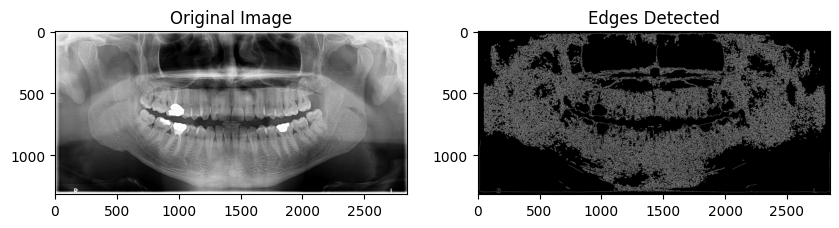

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog
import pickle

def preprocess_image(image):
    """
    Test görüntüsüne ön işlem uygulama (Normalization -> Histogram Equalization -> Keskinleştirme -> Gaussian Filter).
    """
    # Normalizasyon
    image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)

    # Histogram Eşitleme
    image = cv2.equalizeHist(image)

    # Keskinleştirme (Laplacian Yöntemi ile)
    laplacian = cv2.Laplacian(image, cv2.CV_64F)
    sharpened = cv2.convertScaleAbs(image - laplacian)

    # Gaussian Filtresi
    processed_image = cv2.GaussianBlur(sharpened, (5, 5), 0)

    return processed_image

def find_edges(image):
    """
    Görüntüdeki kenarları Canny yöntemiyle bul.
    """
    edges = cv2.Canny(image, 50, 150)
    return edges

def extract_patches_from_edges(image, edges, patch_size):
    """
    Kenarlardan patch'ler çıkar.
    """
    patches = []
    half_patch = patch_size // 2

    # Kenar piksellerinin koordinatlarını al
    y_indices, x_indices = np.where(edges > 0)

    for y, x in zip(y_indices, x_indices):
        if (
            x - half_patch >= 0 and x + half_patch < image.shape[1] and
            y - half_patch >= 0 and y + half_patch < image.shape[0]
        ):
            patch = image[y - half_patch: y + half_patch, x - half_patch: x + half_patch]
            patches.append(patch)

    return patches

def compute_hog_features(patches):
    """
    Patch'ler için HOG özelliklerini hesapla.
    """
    hog_features = []
    for patch in patches:
        features = hog(patch, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=False)
        hog_features.append(features)
    return hog_features

def filter_patches(hog_features, reference_hog, threshold=0.8):
    """
    Patch HOG özelliklerini kaydedilen HOG ile karşılaştır ve benzer olmayanları çıkar.
    """
    filtered_features = []
    for feature in hog_features:
        similarity = np.dot(feature, reference_hog) / (np.linalg.norm(feature) * np.linalg.norm(reference_hog))
        if similarity >= threshold:
            filtered_features.append(feature)
    return filtered_features

# Test görüntüsünü yükleme
image_path = "img2.png"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Görüntüye ön işleme uygula
processed_image = preprocess_image(image)

# Kenar tespiti
edges = find_edges(processed_image)

# Patch boyutu
patch_size = 16

# Kenarlardan patch çıkar
patches = extract_patches_from_edges(processed_image, edges, patch_size)

# HOG özelliklerini hesapla
hog_features = compute_hog_features(patches)

# Kaydedilmiş HOG vektörünü yükle
with open("hog_features.pkl", "rb") as file:
    reference_hog = pickle.load(file)

# Patch'leri filtrele (Benzerlik eşik değeri 0.8)
filtered_features = filter_patches(hog_features, reference_hog, threshold=0.8)

print(f"Filtrelenen HOG özellik sayısı: {len(filtered_features)}")

# Sonucu görselleştir
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image, cmap='gray')

plt.subplot(1, 2, 2)
plt.title("Edges Detected")
plt.imshow(edges, cmap='gray')
plt.show()
